# Project 1 - New York Taxi Data Analysis With Spark

In [1]:
import geopandas as gpd
from shapely import geometry

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp, udf
from pyspark.sql.types import StringType
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
import seaborn as sns

In [2]:
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/07 11:14:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Dataset

### Taxi ride

Each file row after the header represents a single taxi ride in CSV format. 

For each ride, we have some attributes of the cab (a hashed version of the medallion number) as well as the driver (a hashed version of the hack license, which is what licenses to drive taxis are called), some temporal information about when the trip started and ended, and the longitude/latitude coordinates for where the passenger(s) were picked up and dropped off.

In [3]:
taxi_df = (spark.read
             .option("sep", ",")
             .option("header", True)
             .option("inferSchema", True)
             .csv("sample.csv")
            )

taxi_df.show(5)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

### Geojson of the boundaries

Additionally, in the dataset archive, you will find a .geojson file that contains the geographical boundaries of the different boroughs of New York City.
This information is needed to compute the answers to the queries needed on the data

In [4]:
boroughs_gdf = gpd.read_file('nyc-boroughs.geojson')
boroughs_gdf.head()

,boroughCode,borough,@id,geometry
0,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,"POLYGON ((-74.05051 40.56642, -74.04998 40.566..."
1,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,"POLYGON ((-74.05314 40.57770, -74.05406 40.577..."
2,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,"POLYGON ((-74.15946 40.64145, -74.15998 40.641..."
3,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,"POLYGON ((-74.08221 40.64828, -74.08142 40.648..."
4,4,Queens,http://nyc.pediacities.com/Resource/Borough/Qu...,"POLYGON ((-73.83668 40.59495, -73.83671 40.594..."


In [6]:
boroughs_gdf.explore('borough', legend=True)

## 2. [Cleaning] - exclude some outliers

### 2.1. The dropoff time will be after the pickup time

In [7]:
taxi_df = (taxi_df.filter(
    F.col('dropoff_datetime') > F.col('pickup_datetime')
))

### 2.2. Trips will not take more than a few hours to complete

* Compute a new column "Duration" which is the difference between pickup time and drop off time.
    *  using the unix_timestamp function to convert the date time of the respective times into milliseconds since epoch
time of Unix systems.
* After computing, Drop records whose duration is either negative or above a given threshold (= 4 hours).

In [8]:
taxi_df = (taxi_df.withColumn(
    'Duration',
    (unix_timestamp('dropoff_datetime') - unix_timestamp('pickup_datetime')) * 1000
))

In [9]:
taxi_df = (taxi_df.filter(
    (F.col('Duration') >= 0) & (F.col('Duration') <= 4 * 60 * 60 * 1000)
))

## 3. [Additional Features] - pickup_borough, dropoff_borough

Let's add the **pickup_borough** and **dropoff_borough** attributes to the dataframe.\
Shapely API has the *contains* function that test that a point is in polygon. 
1. Pick *pickup_(longitude, latitude)* and *dropout_(longitude, latitude)* and create Point objects in shapely.
2. Check that the points is in which borough by using *contains* function.
3. Add the attributions to the dataframe.

In [10]:
def get_borough(lat, lon, gdf):
    point = geometry.Point(lon, lat)
    for _, row in gdf.iterrows():
        if row['geometry'].contains(point):
            return row['borough']
    return "Other"

# UDF to look up the borough from Point.
get_borough_udf = udf(lambda lat, lon: get_borough(lat, lon, boroughs_gdf), StringType())

In [11]:
taxi_df = (taxi_df.withColumn(
    'pickup_borough',
    get_borough_udf(F.col('pickup_latitude'), F.col('pickup_longitude'))
))

taxi_df = (taxi_df.withColumn(
    'dropoff_borough',
    get_borough_udf(F.col('dropoff_latitude'), F.col('dropoff_longitude'))
))

In [12]:
taxi_df.show(5)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+--------+--------------+---------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|Duration|pickup_borough|dropoff_borough|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+--------+--------------+---------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|       

## 4. [Query2] - idle_time

The average time it takes for a taxi to find its next fare(trip) per destination borough.\
This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up.

### 4.1. Plan

From now, I'll call the time as **idle_time(ms)**.\
We have unique ID codes of the taxi cars in the dataset. So,
1. Create *windowSpec* by an ID code.
2. Sort the *windoeSpec* by *pickup_datetime* in accending order.
3. Create *next_pickup_datime* column using *windowSpec* and **lead** function.
4. Calculate diff times(*idle_time*) from a *dropoff_datetime* to the *next_pickup_datetime*.
5. Clean up outliers(idle_time < 0 or 4hours < idle_time)
8. Average *idle_time* by the number of rides in each *dropoff_borough* using *groupBy* and **agg** function.

This operation can calculate the idle time of the taxi car per destination borough.

### 4.2. Code

In [13]:
# Step 1
windowSpec = Window.partitionBy("medallion") 

# Step 2
windowSpec = windowSpec.orderBy("pickup_datetime") 

# Step 3
taxi_df_idle = (taxi_df.withColumn(
    "next_pickup_datetime",
    F.lead("pickup_datetime", 1).over(windowSpec)
))

# Step 4
taxi_df_idle = (taxi_df_idle.withColumn(
    'idle_time',
    (unix_timestamp('next_pickup_datetime') - unix_timestamp('dropoff_datetime')) * 1000
))

# Step 5
taxi_df_idle = (taxi_df_idle.filter(
    (F.col('idle_time') >= 0) & (F.col('idle_time') <= 4 * 60 * 60 * 1000)
))

idle_time_borough_df = (taxi_df_idle
                        .groupBy('dropoff_borough')
                        .agg(F.avg('idle_time').alias('avg_idle_time'))
                       )

In [14]:
idle_time_borough_df.show()

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=26486Kb max_used=26491Kb free=104585Kb
 bounds [0x0000000106880000, 0x0000000108290000, 0x000000010e880000]
 total_blobs=10259 nmethods=9331 adapters=839
 compilation: disabled (not enough contiguous free space left)


+---------------+------------------+
|dropoff_borough|     avg_idle_time|
+---------------+------------------+
|         Queens|3032493.7360178973|
|          Other|1560393.2394366197|
|       Brooklyn| 2612260.931389975|
|  Staten Island|         4710000.0|
|      Manhattan|1035391.6649183646|
|          Bronx| 2593374.613003096|
+---------------+------------------+



### 4.3. Visualization

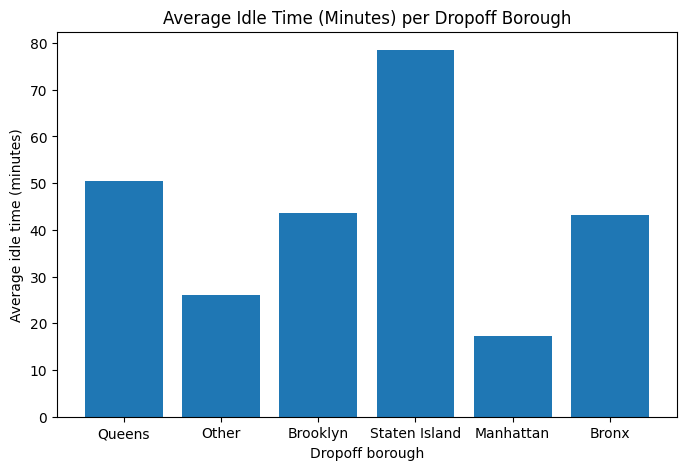

In [15]:
idle_time_borough_pd_df = idle_time_borough_df.toPandas()

plt.figure(figsize = (8, 5))
plt.bar(idle_time_borough_pd_df['dropoff_borough'].values.astype(str), idle_time_borough_pd_df['avg_idle_time'].values/(1000*60))
plt.title('Average Idle Time (Minutes) per Dropoff Borough')
plt.xlabel("Dropoff borough")
plt.ylabel("Average idle time (minutes)")
plt.show()

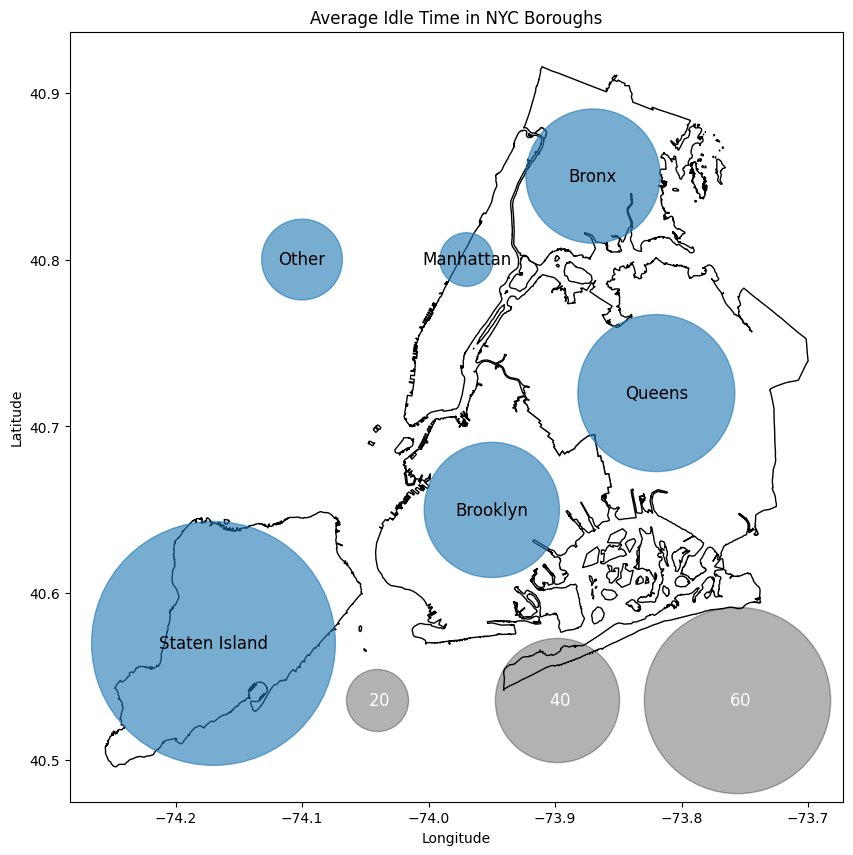

In [179]:
ax = boroughs_gdf.plot(figsize=(10, 10), color='white', edgecolor='black')

# Function to convert idle time to circle radius
def idle_time_to_radius(idle_time, scale=5):
    return idle_time**2 * scale

def borough_to_position(borough):
    position = {
        "Manhattan": (-73.97, 40.8), 
        "Bronx": (-73.87, 40.85), 
        "Queens": (-73.82, 40.72), 
        "Brooklyn": (-73.95, 40.65),
        "Staten Island": (-74.17, 40.57),
        "Other": (-74.1, 40.8)
    }
    return position[borough]

positions = idle_time_borough_pd_df['dropoff_borough'].apply(borough_to_position).values
latitudes = [pos[1] for pos in positions]
longitudes = [pos[0] for pos in positions]

avg_idle_time_minutes = idle_time_borough_pd_df['avg_idle_time'] / (1000 * 60)
marker_sizes = avg_idle_time_minutes.apply(idle_time_to_radius).values

scatter = plt.scatter(longitudes, latitudes, s=marker_sizes, alpha=0.6)
# Plot circles for idle times
for idx, row in idle_time_borough_pd_df.iterrows():
    borough_center_x, borough_center_y = borough_to_position(row['dropoff_borough'])
    plt.text(borough_center_x, borough_center_y, row['dropoff_borough'], fontsize=12, ha='center', va='center', color='black')
    
plt.title('Average Idle Time in NYC Boroughs')

handles, labels = scatter.legend_elements(prop="sizes", num=4, alpha=0.3, func=lambda s: (s / 5) ** (0.5))  # Scale back the marker sizes for the legend
plt.legend(handles, labels, columnspacing=9, frameon=False, ncol=3, loc='lower right', bbox_to_anchor=(0.9, 0.1), handletextpad=-1.5, fontsize=12, labelcolor='white')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 5. [Query3] same_borough_df

The number of trips that started and ended within the same borough.

### 5.1. Plan

1. Count the number of trips that *pickup_borough* and *dropoff_borough* are same using the filter function.
2. Group by the borough.

### 5.2. Code

In [180]:
same_borough_df = (taxi_df.filter(
    F.col('pickup_borough') == F.col('dropoff_borough')
))

count_trip_same_borough = (same_borough_df
                           .groupBy('pickup_borough').count()
                          )

In [181]:
count_trip_same_borough.show()

+--------------+-----+
|pickup_borough|count|
+--------------+-----+
|        Queens| 1369|
|         Other| 1533|
|      Brooklyn| 1062|
| Staten Island|    1|
|     Manhattan|83464|
|         Bronx|   49|
+--------------+-----+



### 5.3. Visualization

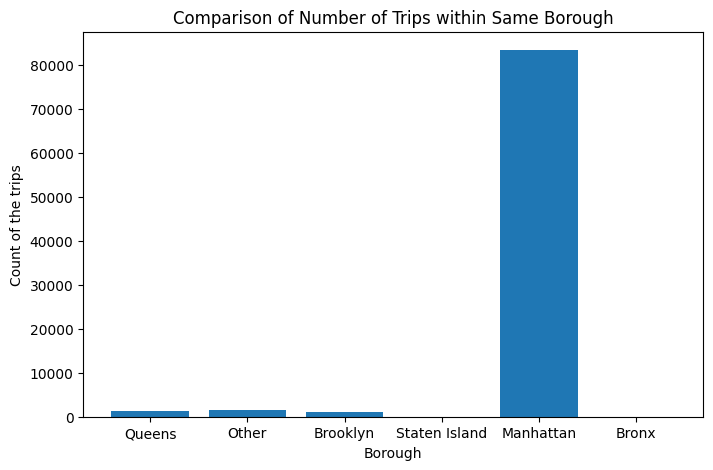

In [182]:
count_trip_same_borough_pd = count_trip_same_borough.toPandas()

plt.figure(figsize = (8, 5))
plt.bar(count_trip_same_borough_pd['pickup_borough'].astype(str), count_trip_same_borough_pd['count'])
plt.title('Comparison of Number of Trips within Same Borough')
plt.xlabel("Borough")
plt.ylabel("Count of the trips")
plt.show()

## 6. [Query4] different_borough_df

The number of trips that started in one borough and ended in another one

### 6.1. Plan

1. Count the number of trips that *pickup_borough* and *dropoff_borough* are different using the filter function.

### 6.2. Code

In [183]:
different_borough_df = (taxi_df.filter(
    F.col('pickup_borough') != F.col('dropoff_borough')
))

count_trip_different_borough = (different_borough_df
                           .groupBy('pickup_borough', 'dropoff_borough').count()
                          )

In [184]:
print(f'Number of trips that has different pickup borough and dropoff borough: {different_borough_df.count()}')

Number of trips that has different pickup borough and dropoff borough: 12072


In [185]:
count_trip_different_borough.show()

+--------------+---------------+-----+
|pickup_borough|dropoff_borough|count|
+--------------+---------------+-----+
|      Brooklyn|      Manhattan|  773|
|         Other|         Queens|   16|
|        Queens|          Bronx|  100|
|      Brooklyn|         Queens|  115|
|        Queens|  Staten Island|    2|
|     Manhattan|  Staten Island|    9|
|     Manhattan|       Brooklyn| 1923|
|     Manhattan|         Queens| 3943|
|     Manhattan|          Bronx|  244|
|         Other|      Manhattan|  103|
|        Queens|      Manhattan| 3697|
|         Bronx|      Manhattan|   25|
|     Manhattan|          Other|  393|
|      Brooklyn|          Other|   10|
|         Other|       Brooklyn|    9|
|        Queens|       Brooklyn|  597|
|        Queens|          Other|  106|
|         Bronx|          Other|    3|
|         Bronx|         Queens|    2|
| Staten Island|         Queens|    1|
+--------------+---------------+-----+
only showing top 20 rows



### 6.3. Visualization

This is the heatmap of volume of trips between different boroughs.

In [186]:
count_trip_borough = (taxi_df
                       .groupBy('pickup_borough', 'dropoff_borough').count()
                      )

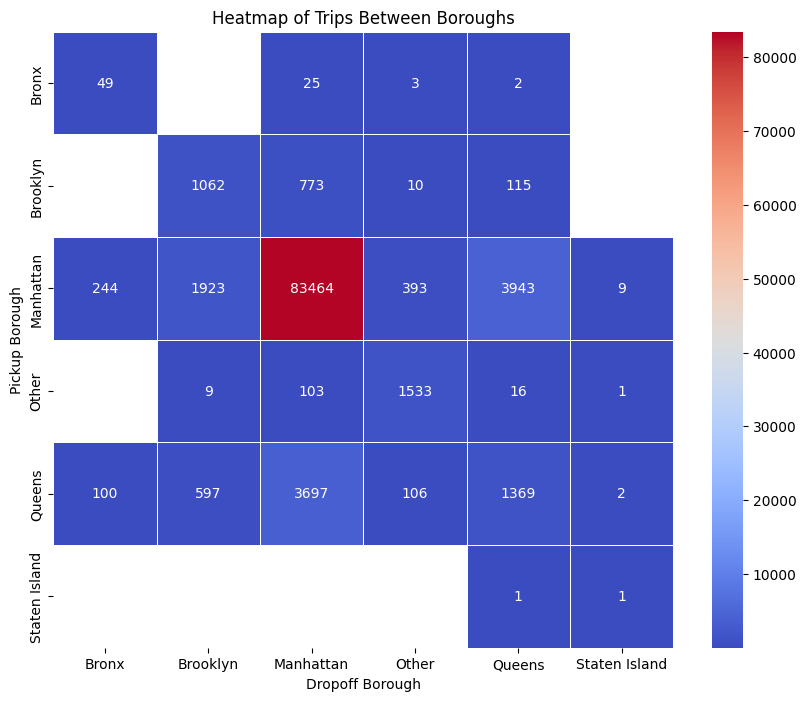

In [187]:
count_trip_borough_pd = count_trip_borough.toPandas()
count_trip_borough_pd['count'] = count_trip_borough_pd['count'].fillna(0).astype(int)
pivot_table = count_trip_borough_pd.pivot(index="pickup_borough", columns="dropoff_borough", values="count")

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="coolwarm", linewidths=.5)
plt.title("Heatmap of Trips Between Boroughs")
plt.ylabel('Pickup Borough')
plt.xlabel('Dropoff Borough')
plt.show()

## 7. [Query1] - Utilization (i.e. sum of idle_time)

Utilization is the fraction of time that a cab is on the road and is occupied by one or more passengers.\
This is per taxi/driver. This can be computed by computing the idle time per taxi.

One factor that impacts utilisation is the passenger’s destination.\
e.g.)\
A cab that drops off passengers near Union Square at midday is much more likely to find its next fare in just a minute or two, whereas a cab that drops someone off at 2 AM on Staten Island may have to drive back to Manhattan before it find its next fare.

### 7.1. Plan

The utilization would be vary depending on the destination borough. So, at the end, we need to group by destination borough.

1. Calculate the sum of *idle_time* as **total_idle_time** on each taxi ID and dropoff_borough.
2. Calculate the sum of *trip_time* as **total_trip_time** on each taxi ID.
3. Calculate the **total_ondudy_time** by *total_idle_time + total_trip_time* on each taxi ID.
4. Calculate the **trip_time_times_passenger** by summing up *trip_time * number of passenger*
5. Calculate **utilization rate** by *trip_time_passenger_count* / *total_ondudy_time* and average it on each dropoff_borough.

### 7.2. Code

In [188]:
each_taxi_idle = (taxi_df_idle
                  .groupBy('medallion', 'dropoff_borough')
                  .agg(
                      F.sum('idle_time').alias('total_idle_time'),
                      (F.sum('trip_time_in_secs') * 1000).alias('total_trip_time'),
                      F.sum((F.col('passenger_count') * (F.col('trip_time_in_secs') * 1000))).alias('total_trip_time_times_passenger')
                  )
                  .withColumn(
                      'total_onduty_time',
                      (F.col('total_trip_time') + F.col('total_idle_time'))
                  ))

In [189]:
each_taxi_idle.show(5)

+--------------------+---------------+---------------+---------------+-------------------------------+-----------------+
|           medallion|dropoff_borough|total_idle_time|total_trip_time|total_trip_time_times_passenger|total_onduty_time|
+--------------------+---------------+---------------+---------------+-------------------------------+-----------------+
|002E3B405B6ABEA23...|      Manhattan|       10620000|        7560000|                        7560000|         18180000|
|002E3B405B6ABEA23...|         Queens|        5520000|        2100000|                        2100000|          7620000|
|0030AD2648D81EE87...|      Manhattan|         720000|         540000|                         540000|          1260000|
|0036961468659D0BF...|      Manhattan|       19740000|       10620000|                       26640000|         30360000|
|0038EF45118925A51...|      Manhattan|       15120000|        9960000|                       49800000|         25080000|
+--------------------+----------

In [190]:
borough_avg_idle_time = (each_taxi_idle
                        .groupBy('dropoff_borough')
                        .agg(
                            F.sum('total_trip_time').alias('total_trip_time_overall'),
                            F.sum('total_onduty_time').alias('total_onduty_time_overall'),
                            F.sum('total_trip_time_times_passenger').alias('total_trip_time_times_passenger_overall')
                        )
                        .withColumn(
                            'utilization_rate',
                            F.col('total_trip_time_times_passenger_overall') / F.col('total_onduty_time_overall')
                        ))

In [191]:
borough_avg_idle_time.show()

+---------------+-----------------------+-------------------------+---------------------------------------+-------------------+
|dropoff_borough|total_trip_time_overall|total_onduty_time_overall|total_trip_time_times_passenger_overall|   utilization_rate|
+---------------+-----------------------+-------------------------+---------------------------------------+-------------------+
|         Queens|             5426895000|              18982142000|                            11986148000| 0.6314433850510653|
|          Other|             1379278000|               4148976000|                             3091558000|  0.745137595397033|
|       Brooklyn|             3301364000|              10649654000|                             7141244000| 0.6705611280892319|
|  Staten Island|               15720000|                 53400000|                               20100000|0.37640449438202245|
|      Manhattan|            47341175000|             131239997000|                           1025576800

### 7.3 Visualization

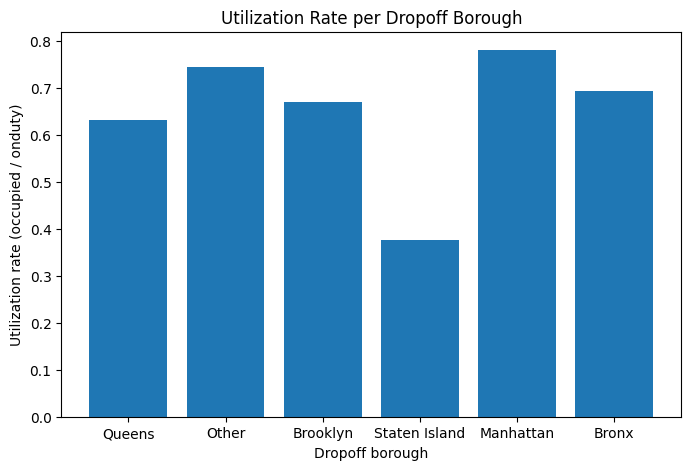

In [192]:
borough_avg_idle_time_pd = borough_avg_idle_time.toPandas()

plt.figure(figsize = (8, 5))
plt.bar(borough_avg_idle_time_pd['dropoff_borough'].values.astype(str), borough_avg_idle_time_pd['utilization_rate'].values)
plt.title('Utilization Rate per Dropoff Borough')
plt.xlabel("Dropoff borough")
plt.ylabel("Utilization rate (occupied / onduty)")
plt.show()

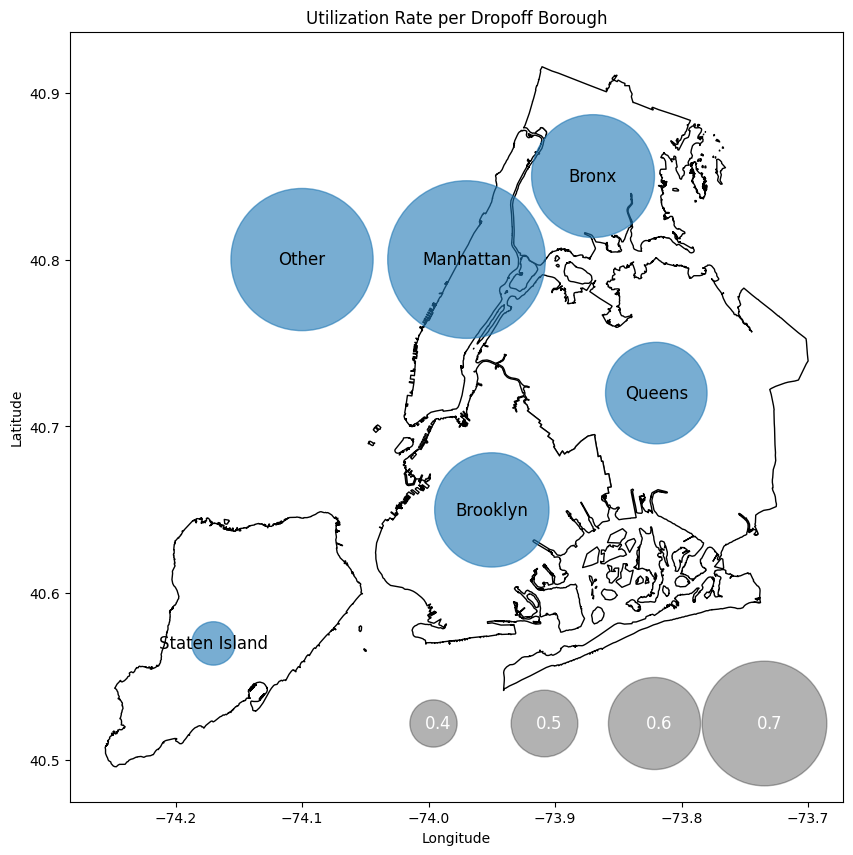

In [211]:
ax = boroughs_gdf.plot(figsize=(10, 10), color='white', edgecolor='black')

# Function to convert idle time to circle radius
def utilization_rate_to_radius(util, scale=40):
    return (util+1)**10 * scale

def borough_to_position(borough):
    position = {
        "Manhattan": (-73.97, 40.8), 
        "Bronx": (-73.87, 40.85), 
        "Queens": (-73.82, 40.72), 
        "Brooklyn": (-73.95, 40.65),
        "Staten Island": (-74.17, 40.57),
        "Other": (-74.1, 40.8)
    }
    return position[borough]

positions = borough_avg_idle_time_pd['dropoff_borough'].apply(borough_to_position).values
latitudes = [pos[1] for pos in positions]
longitudes = [pos[0] for pos in positions]

marker_sizes = borough_avg_idle_time_pd['utilization_rate'].apply(utilization_rate_to_radius).values

scatter = plt.scatter(longitudes, latitudes, s=marker_sizes, alpha=0.6)
# Plot circles for idle times
for idx, row in borough_avg_idle_time_pd.iterrows():
    borough_center_x, borough_center_y = borough_to_position(row['dropoff_borough'])
    plt.text(borough_center_x, borough_center_y, row['dropoff_borough'], fontsize=12, ha='center', va='center', color='black')
    
plt.title('Utilization Rate per Dropoff Borough')

handles, labels = scatter.legend_elements(prop="sizes", num=4, alpha=0.3, func=lambda s: ((s/40) ** (0.1)) - 1)  # Scale back the marker sizes for the legend
plt.legend(handles, labels, columnspacing=4.5, frameon=False, ncol=4, loc='lower right', bbox_to_anchor=(0.94, 0.07), handletextpad=-1.5, fontsize=12, labelcolor='white')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 8. Reference

* https://geopandas.org/en/stable/docs.html
* https://spark.apache.org/docs/latest/api/python/index.html